# Growing Neural Cellular Automata

This notebook contains code to reproduce experiments and figures for the Modeling Morphogenisis in 3d: Neural cellular Automata

In [ ]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import zipfile
import numpy as np
import matplotlib.pylab as pl

import tensorflow as tf

from IPython.display import Image, HTML, clear_output

import csv
import numpy as np
from IPython.display import Image, HTML, clear_output
import matplotlib.pyplot as plt

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)


def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()


def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))



def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img




In [ ]:
#@title Choose and load data from url
import pandas as pd
import numpy as np
import io
import requests

MODEL_3D = "torus_19x6x19.csv" #@param ["torus_19x6x19.csv", "lizard_44x19x8.csv", "bird_15x28x28.csv", "spider_29x10x31.csv", "knight_18x8x15.csv"]

urls = {
    'knight': 'https://raw.githubusercontent.com/Aadityaza/3d-Growing-neural-cellular-automata/main/Entity/knight_18x8x15.csv?token=GHSAT0AAAAAACCHMXX7O5NLF5CQ45A6YLQMZCUWWFA',
    'bird': 'https://raw.githubusercontent.com/Aadityaza/3d-Growing-neural-cellular-automata/main/Entity/bird_15x28x28.csv',
    'lizard': 'https://raw.githubusercontent.com/Aadityaza/3d-Growing-neural-cellular-automata/main/Entity/lizard_44x19x8.csv?token=GHSAT0AAAAAACCHMXX7CPE6MLJMAJJZLAQWZCUXGJQ',
    'torus': 'https://raw.githubusercontent.com/Aadityaza/3d-Growing-neural-cellular-automata/main/Entity/torus_19x6x19.csv?token=GHSAT0AAAAAACCHMXX66DAJD3J6IIOICINOZCUXF4A',
    'spider': 'https://raw.githubusercontent.com/Aadityaza/3d-Growing-neural-cellular-automata/main/Entity/spider_29x10x31.csv'
}

entity=MODEL_3D.split('_')[0]

url=urls[entity]

df = pd.read_csv(url,encoding= 'unicode_escape')

arr = np.array(df)

file_name = ((url.split('/')[-1]).split('?')[0]).split('.')[0]
dimention = [int(x) for x in file_name.split("_")[-1].split("x")]

max_dim=int(np.max(dimention))

print('Data loading succesfull')
print('File name:', file_name)
print('Data shape:', arr.shape)
SIZE_X=dimention[0]
SIZE_Y=dimention[1]
SIZE_Z=dimention[2]

Data loading succesfull
File name: torus_19x6x19
Data shape: (1399, 6)


In [ ]:
#@title load data from local file 
#@markdown Provide path to your csv file
path = "/content/lizard_24x19x8.csv" #@param {type:"string"}
file_name = path.split('/')[-1].split('.')[0]
dimention = [int(x) for x in file_name.split("_")[-1].split("x")]
max_dim=int(np.max(dimention))

with open(path, 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
SIZE_X=dimention[0]
SIZE_Y=dimention[1]
SIZE_Z=dimention[2]

arr = np.array(data).astype(float)

In [ ]:
#@title Define a function to returns a single layer of voxel 
def return_zLayer_t(arr,z_l):
  z= np.array([arr[arr[:, 2] ==  z_l]])
  Zxy=z[0][...,:6].astype(int)

  Z=np.zeros((SIZE_X,SIZE_Y))
  R=np.zeros((SIZE_X,SIZE_Y))
  G=np.zeros((SIZE_X,SIZE_Y))
  B=np.zeros((SIZE_X,SIZE_Y))

  for i in Zxy:
    Z[i[0]][i[1]]=1
    R[i[0]][i[1]]=i[3]
    G[i[0]][i[1]]=i[4]
    B[i[0]][i[1]]=i[5]
  return R,G,B,Z

In [ ]:
#@title Stack up layers 
r_stack,g_stack,b_stack,z_stack=return_zLayer_t(arr,0)
for i in range(1,SIZE_Z):
  r,g,b,a=return_zLayer_t(arr,i)
  r_stack = np.dstack((r_stack,r))
  g_stack = np.dstack((g_stack,g))
  b_stack = np.dstack((b_stack,b))
  z_stack = np.dstack((z_stack,a))

In [ ]:
#@title Display all layer
for i in range(SIZE_X):
  img= np.stack((r_stack[i]/255,g_stack[i]/255,b_stack[i]/255,z_stack[i]),axis=2)
  imshow(zoom(img))
  print('layer: '+str(i))


layer: 0


layer: 1


layer: 2


layer: 3


layer: 4


layer: 5


layer: 6


layer: 7


layer: 8


layer: 9


layer: 10


layer: 11


layer: 12


layer: 13


layer: 14


layer: 15


layer: 16


layer: 17


layer: 18


In [ ]:
#@title  Parameters
#@markdown Choose for options below
TRAINING_TYPE = "structure with color" #@param ["structure only", "structure with color"]
flag = True if TRAINING_TYPE == "structure with color" else False

FACE_COLOR='green'#@param['sienna','silver','dimgray','k','green']


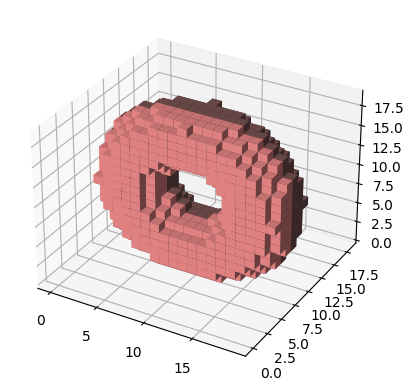

(19, 6, 19, 4)


In [ ]:
#@title Define target  { vertical-output: true}

target=np.stack((r_stack/255,g_stack/255,b_stack/255,z_stack),axis=-1)

z_resized = np.pad(z_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
r_resized = np.pad(r_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
g_resized = np.pad(g_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
b_resized = np.pad(b_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
target_resized=np.stack((r_resized/255,g_resized/255,b_resized/255,z_resized),axis=-1)

fig = plt.figure()
ax=fig.add_subplot(projection='3d')
if flag:
  ax.voxels(target_resized[...,3], facecolors=target_resized[..., :3] )
else:
  ax.voxels(target_resized[...,3], facecolors=FACE_COLOR)

# Show the plot
plt.show()
print(target.shape)

In [ ]:
#@title Defining seed 
#@markdown Choose no of channel
NUMBER_OF_CHANNELS = "16" #@param [16,20,24]
Channel=int(NUMBER_OF_CHANNELS)
seed = np.zeros([1,SIZE_X,SIZE_Y,SIZE_Z,Channel],np.float32)
seed[:,SIZE_X//2,SIZE_Y//2,SIZE_Z//2,:4]=1
print("Shape of seed:")
print(seed.shape)


Shape of seed:
(1, 19, 6, 19, 16)


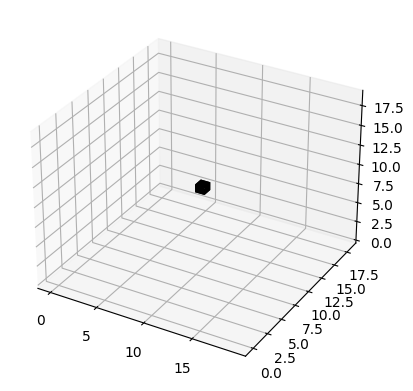

In [ ]:
#@title Display seed { vertical-output: true}
temp = seed[0][...,:4]
z_resized = np.pad(temp[...,0], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')


fig = plt.figure()
ax=fig.add_subplot(projection='3d')
if flag:
  r_resized = np.pad(temp[...,1], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
  g_resized = np.pad(temp[...,2], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
  b_resized = np.pad(temp[...,3], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')

  obj=np.stack((r_resized/255,g_resized/255,b_resized/255,z_resized),axis=-1)
  ax.voxels(obj[...,3], facecolors=obj[..., :3] )
else:
  ax.voxels(z_resized, facecolors=FACE_COLOR )

# Show the plot
plt.show()
plt.close()

In [ ]:
#@title Building Model  Conv3D multi channel

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv3D
from keras.models import Sequential, load_model

def get_living_mask(x):
  alpha = x[..., 3:4]
  return  tf.cast(tf.nn.max_pool3d(alpha,3,1,'SAME') > 0.1,tf.float32)

class CA(tf.Module):
  def __init__(self):
    self.model=tf.keras.Sequential([
        Conv3D(filters=Channel*3, kernel_size=3, padding='same',input_shape=(SIZE_X,SIZE_Y,SIZE_Z,Channel), activation=tf.nn.relu),
        Conv3D(filters=Channel, kernel_size=3, padding='same',kernel_initializer=tf.zeros),
    ])
  
  @tf.function
  def __call__(self,x):
    #alive_mask= get_living_mask(x)
    update_mask = tf.floor(tf.random.uniform(x.shape) + 0.5)
    x= x+self.model(x)*update_mask
    #x *= alive_mask
    return x


In [ ]:
#@title Running randomly initialized CA for some ittirations{vertical-output:true}
ca=CA()
x=seed

ittiration=100
for i in range(ittiration):
  x=ca(x)
  

In [ ]:
#@title Model summary S
ca.model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 19, 6, 19, 48)     20784     
                                                                 
 conv3d_1 (Conv3D)           (None, 19, 6, 19, 16)     20752     
                                                                 
Total params: 41,536
Trainable params: 41,536
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title Test / Visualize loss minimization (dont run)

trainer=tf.optimizers.Adam(1e-3)

ittiration =20

for k in range(ittiration):
  with tf.GradientTape() as g:
    x=seed    
    print("Target ")   
    imshow(zoom(target[7][...,3]))
    print("NCA in ittiration:"+str(k))     
    
    for i in range(100): 
      x=ca(x)
    target_loss = tf.reduce_mean(tf.square(x[...,:4] - tf.cast(target, tf.float32)))
    diff_loss=0
    for i in tf.range(50):
      prev_x=x
      x=ca(x)
      diff_loss+=tf.reduce_mean(tf.square(x-prev_x))
    loss=target_loss+diff_loss 
    if i %20==0:
      imshow(zoom(x[0][...,3][7]))
    clear_output(True)
      
  #params=ca.trainable_variables
  #grads=g.gradient(loss, params) 
  #grads=[g/(tf.norm(g)+1e-8) for g in grads]
  #trainer.apply_gradients(zip(grads,params))
  #print(loss.numpy())

In [ ]:
#@title Defining loss & train step
BATCH_SIZE = 1 #@param {type:"slider", min:1, max:16, step:1}
#defining optimizer
lr=tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000],[1e-3,3e-4])
trainer=tf.optimizers.Adam(lr)
loss_log=[]
mse_loss = tf.keras.losses.MeanSquaredError()
@tf.function
def training_step():
  with tf.GradientTape() as g:
    x=tf.repeat(seed,BATCH_SIZE,0)
    N="100"#@param[50,100,200]
    ittiration =int(N)
    for i in range(ittiration):
      x=ca(x)
      
      if flag:
        loss = mse_loss(x[..., :4], tf.cast(target, tf.float32))
      else:
        loss = mse_loss(x[..., :4][...,3], tf.cast(target[...,3], tf.float32))  

      
  params=ca.trainable_variables
  grads=g.gradient(loss, params) 
  grads=[g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads,params))
  return loss,x

In [ ]:
#@title Refrance layer from target to compare training progerss {vertical-output:true}
print("Target :")

if flag:
  imshow(zoom(np.hstack((target[0, ..., :4],target[7, ..., :4],target[9, ..., :4]))))
  
else:
  imshow(zoom(np.hstack((target[0, ..., 3],target[7, ..., 3],target[9, ..., 3])))) 


Target :


Batch : 0 refrence layer 0,7,9


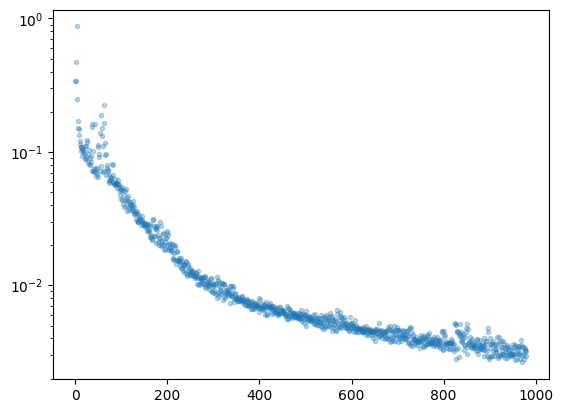

980 0.0029531973


In [ ]:
 
#@title Training loop {vertical-output:true}
TRAINING_ITTIRATION="1000"#@param[500,1000,3000,5000,10000]
 
for i in range(int(TRAINING_ITTIRATION)):
  x=seed
  loss,x=training_step()   
  loss_log.append(loss.numpy())
  if i%20==0:
    clear_output(True)
  
    for n in range (1):
      print("Batch :",n,"refrence layer 0,7,9") 
      if flag:
        temp=temp = x[n][...,:4]
        imshow(zoom(np.hstack((temp[0], temp[7], temp[9]))))
      else:
        temp=temp = x[n][...,3]
        imshow(zoom(np.hstack((temp[0], temp[7], temp[9]))))
      
    print()
    pl.plot(loss_log,'.',alpha=0.3)
    pl.yscale('log')
    pl.show()
    print(i,loss.numpy(),flush=True)

In [ ]:
#@title Run the trained model
x=seed
ittiration="100"#@param[100,200,300]
for i in range(int(ittiration)):
  x=ca(x)
  clear_output(True)
  temp = x[0][...,:4]
  imshow(zoom(temp[6][...,:4][...,:4]))
  print() 
  print('step N :'+str(i))


step N :99


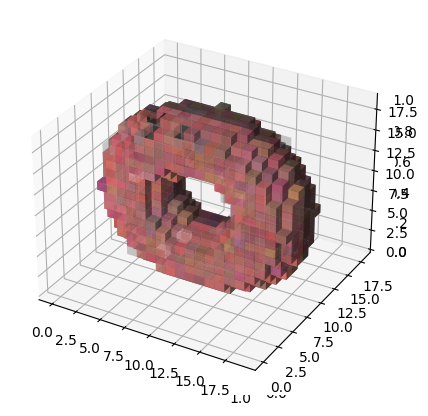

(19, 6, 19, 4)


In [ ]:
#@title Final structure generated {vertical-output:true}
fig = plt.figure(figsize=(5,5))
ax=fig.add_subplot(projection='3d')
temp = x[0][...,:4]
max_v=np.max(temp)
temp = np.where(temp < 0, 0, temp)
temp=temp/max_v
z_resized = np.pad(temp[...,3], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
r_resized = (np.pad(temp[...,0], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
g_resized = (np.pad(temp[...,1], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
b_resized = (np.pad(temp[...,2], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))

obj=np.stack((r_resized,g_resized,b_resized,z_resized),axis=-1)

ax=fig.add_subplot(projection='3d')
xx = np.where(z_resized < 0.1, 0, z_resized)
if flag:
  ax.voxels(xx, facecolors=obj[...,:4])
else:
  ax.voxels(xx, facecolors=FACE_COLOR)


plt.show()
plt.close()
print(target.shape)

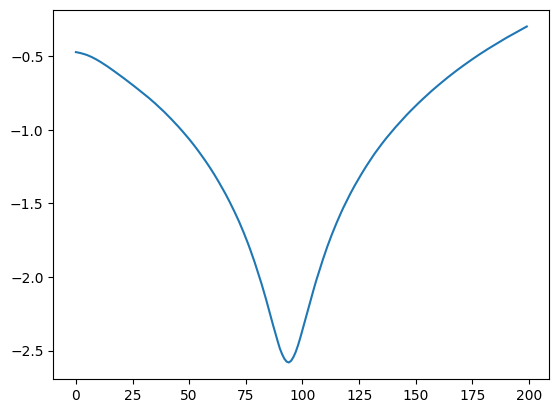

In [ ]:
#@title loss over life time {vertical-output:true}

mse_loss = tf.keras.losses.MeanSquaredError()
loss_log1=[]
x=seed
ittiration="200"#@param[100,200,300,1000]
for i in range(int(ittiration)):
  x=ca(x)
  loss=  mse_loss(x[..., :4], tf.cast(target, tf.float32))
  loss_log1.append(loss.numpy())
    
  

pl.plot(np.log10(loss_log1))

In [ ]:
#@title Visualize structure generation (plot image  of each stage) (loaded)
x=seed
ittiration="100"#@param[100,120,300]
if not os.path.exists('img'):
  os.mkdir('img')
else:
  import shutil
  shutil.rmtree('img')
  os.mkdir('img')

for i in range(int(ittiration)):
  x=ca(x)
  #if i==60:
    #msk = np.ones([1,SIZE_X,SIZE_Y,SIZE_Z,Channel],np.float32)
    #msk[ 0,:SIZE_X//2,:, :, :] = 0
    #x=x*msk
  
  clear_output(True) 
   
  fig = plt.figure(figsize=(8,8))
  ax=fig.add_subplot(projection='3d')
  temp = x[0][...,:4]
  max_v=np.max(temp) 
  temp = np.where(temp < 0, 0, temp)
  temp=temp/max_v
  z_resized = np.pad(temp[...,3], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
  r_resized = (np.pad(temp[...,0], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
  g_resized = (np.pad(temp[...,1], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
  b_resized = (np.pad(temp[...,2], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))

  ax=fig.add_subplot(projection='3d')
  obj=np.stack((r_resized,g_resized,b_resized,z_resized),axis=-1)
  
  xx = np.where(z_resized < 0.1, 0, z_resized)
  if flag:
    ax.voxels(xx, facecolors=obj[...,:3])
  else:
    ax.voxels(xx, facecolors=FACE_COLOR)
  
  from mpl_toolkits.mplot3d import Axes3D
  #ax.view_init(azim=i)
  ax.view_init()

  filename = "img/voxel_plot_{}.png".format(i)
  plt.savefig(filename)

  





In [ ]:
#@title Convertingn image sequence to video 
from moviepy.editor import ImageSequenceClip

file_list = ["img/voxel_plot_{}.png".format(i) for i in range(1,int(ittiration))]

clip = ImageSequenceClip(file_list, fps=6)
clip.write_videofile("growth.mp4")


Moviepy - Building video growth.mp4.
Moviepy - Writing video growth.mp4



Moviepy - Done !
Moviepy - video ready growth.mp4


In [ ]:
 
#@title Training loop with pooling {vertical-output:true}
#@title Defining loss & train step
BATCH_SIZE = 1 #@param {type:"slider", min:1, max:16, step:1}
#defining optimizer
lr=tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000],[1e-3,3e-4])
trainer=tf.optimizers.Adam(lr)
loss_log=[]
mse_loss = tf.keras.losses.MeanSquaredError()

pool=np.repeat(seed,BATCH_SIZE,0)

@tf.function
def training_step(x):
  with tf.GradientTape() as g:
    N="100"#@param[50,100,200]
    ittiration =int(N)
    for i in range(ittiration):
      x=ca(x)
    if flag:
      loss = mse_loss(x[..., :4], tf.cast(target, tf.float32))
    else:
      loss = mse_loss(x[..., :4][...,3], tf.cast(target[...,3], tf.float32)) 
    

  params=ca.trainable_variables
  grads=g.gradient(loss, params) 
  grads=[g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads,params))
  return loss,x

TRAINING_ITTIRATION="500"#@param[500,1000,3000,5000,10000]
 
for i in range(int(TRAINING_ITTIRATION)):
  batch_idx=np.random.choice(len(pool),8, replace=True)
  x0=pool[batch_idx]
  x0[:1]=seed
  loss,x=training_step(x0)   
  loss_log.append(loss.numpy())
  if i%10==0:
    print()
    pl.plot(loss_log,'.',alpha=0.3)
    pl.yscale('log')
    pl.show()
    print(i,loss.numpy(),flush=True)

In [ ]:
#@title Save mode
to_drive='False'#@param['True','False']
folder_path='/content/'
if to_drive=='True':
  folder_path = '/content/drive/MyDrive/voxel/models/'

In [ ]:
#@title Save the trained model
import pickle


print(folder_path)
# Save the model to a file
file_name = path.split('/')[-1].split('.')[0]
model_name ='3dNCA-'+file_name+'x'+str(Channel)+'x'+str(flag)+'.pkl'
with open(folder_path+model_name, 'wb') as f:
    pickle.dump(ca, f)
print(model_name)

The code below is for loding and testing already trained models

In [ ]:
#@title  Load the saved model from the file

#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import zipfile
import numpy as np
import matplotlib.pylab as pl

import tensorflow as tf

from IPython.display import Image, HTML, clear_output

import csv
import numpy as np
from IPython.display import Image, HTML, clear_output
import matplotlib.pyplot as plt

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)


def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()


def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))



def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img



import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv3D
from keras.models import Sequential, load_model


def get_living_mask(x):
  alpha = x[..., 3:4]
  return  tf.cast(tf.nn.max_pool3d(alpha,3,1,'SAME') > 0.1,tf.float32)

class CA(tf.Module):
  def __init__(self):
    self.model=tf.keras.Sequential([
        Conv3D(filters=Channel*3, kernel_size=3, padding='same',input_shape=(SIZE_X,SIZE_Y,SIZE_Z,Channel), activation=tf.nn.relu),
        Conv3D(filters=Channel, kernel_size=3, padding='same',kernel_initializer=tf.zeros),
    ])
  
  @tf.function
  def __call__(self,x):
    alive_mask= get_living_mask(x)
    update_mask = tf.floor(tf.random.uniform(x.shape) + 0.5)
    x= x+self.model(x)*update_mask
    x *= alive_mask
    return x

#------------------------------------------------------------------------------------



import pickle

model_name = "3dGNCA-torus_19x6x19x24xTrue.pkl" #@param ["3dGNCA-torus_19x6x19x24xTrue.pkl","3dNCA-bird-c_15x28x28x24xTrue.pkl"]

folder_path='/content/'
if to_drive=='True':
  from google.colab import drive
  drive.mount('/content/drive')
  folder_path = '/content/drive/MyDrive/voxel/models/'
  file_path = folder_path+model_name
else:
  file_path='/content/3dNCA-lizard_44x19x8x16xTrue.pkl' #@param {type:"string"}

print(file_path)
with open(file_path ,'rb') as f:
    GNCA = pickle.load(f)

file_path = file_path.split('/')[-1].split('.')[0]
param = [str(x) for x in file_path.split("_")[-1].split("x")]
print(param)
SIZE_X=int(param[0])
SIZE_Y=int(param[1])
SIZE_Z=int(param[2])
Channel=int(param[3])
flag=param[4]=='True'
print(flag)
max_dim=max(SIZE_X,SIZE_Y,SIZE_Z)




/content/3dNCA-lizard_44x19x8x16xTrue.pkl
['44', '19', '8', '16', 'True']
True


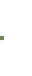


step N :199


In [ ]:
#@title Run the saved model
import numpy as np
seed = np.zeros([1,SIZE_X,SIZE_Y,SIZE_Z,Channel],np.float32)
seed[:,SIZE_X//2,SIZE_Y//2,SIZE_Z//2,:4]=1
print("Shape of seed:")
print(seed.shape)

x=seed
ittiration="200"#@param[100,200,300]
for i in range(int(ittiration)):
  x=GNCA(x)
  if  i==50:
    msk = np.ones([1,SIZE_X,SIZE_Y,SIZE_Z,Channel],np.float32)
    msk[ :,:SIZE_X//2, :, :, :] = 0
    x=x*msk
  clear_output(True)
  temp = x[0][...,:4]
  imshow(zoom(temp[7][...,:4]))
  print() 
  print('step N :'+str(i))

In [ ]:
#@title Final structure generated  (loaded)
fig = plt.figure(figsize=(5,5))
ax=fig.add_subplot(projection='3d')
temp = x[0][...,:4]
max_v=np.max(temp)
temp = np.where(temp < 0, 0, temp)
temp=temp/max_v
z_resized = np.pad(temp[...,3], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
r_resized = (np.pad(temp[...,0], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
g_resized = (np.pad(temp[...,1], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
b_resized = (np.pad(temp[...,2], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))

obj=np.stack((r_resized,g_resized,b_resized,z_resized),axis=-1)

ax=fig.add_subplot(projection='3d')
xx = np.where(z_resized < 0.1, 0, z_resized)
if flag:
  ax.voxels(xx, facecolors=obj[...,:3])
else:
  ax.voxels(xx, facecolors=FACE_COLOR)


plt.show()
plt.close()
print(xx.shape)

In [ ]:
#@title Visualize structure generation (plot image  of each stage) (loaded)
x=seed
ittiration="200"#@param[100,200,300]
if not os.path.exists('img'):
  os.mkdir('img')
else:
  import shutil
  shutil.rmtree('img')
  os.mkdir('img')

for i in range(int(ittiration)):
  if  i==60:
    
  x=GNCA(x)
   #if i==50:
    #msk = np.ones([1,SIZE_X,SIZE_Y,SIZE_Z,Channel],np.float32)
    #msk[ 0,:SIZE_X//2,:, :, :] = 0
    #x=x*msk
  
  clear_output(True) 
   
  fig = plt.figure(figsize=(5,5))
  ax=fig.add_subplot(projection='3d')
  temp = x[0][...,:4]
  max_v=np.max(temp) 
  temp = np.where(temp < 0, 0, temp)
  temp=temp/max_v
  z_resized = np.pad(temp[...,3], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
  r_resized = (np.pad(temp[...,0], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
  g_resized = (np.pad(temp[...,1], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
  b_resized = (np.pad(temp[...,2], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))

  ax=fig.add_subplot(projection='3d')
  obj=np.stack((r_resized,g_resized,b_resized,z_resized),axis=-1)
  
  xx = np.where(z_resized < 0.1, 0, z_resized)
  if flag:
    ax.voxels(xx, facecolors=obj[...,:3])
  else:
    ax.voxels(xx, facecolors=FACE_COLOR)
  
  from mpl_toolkits.mplot3d import Axes3D
  ax.view_init(azim=i)

  filename = "img/voxel_plot_{}.png".format(i)
  plt.savefig(filename)

  





In [ ]:
#@title Visualize structure generation (plot image  of each stage)  (loaded)
x=seed
ittiration="100"#@param[100,200,300]
if not os.path.exists('img'):
  import shutil
  shutil.rmtree('img')
  os.mkdir('img')

for i in range(int(ittiration)):
  x=GNCA(x)
  clear_output(True) 
   
  fig = plt.figure(figsize=(5,5))
  ax=fig.add_subplot(projection='3d')
  temp = x[0][...,:4]
  max_v=np.max(temp) 
  temp = np.where(temp < 0, 0, temp)
  temp=temp/max_v
  z_resized = np.pad(temp[...,3], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
  r_resized = (np.pad(temp[...,0], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
  g_resized = (np.pad(temp[...,1], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))
  b_resized = (np.pad(temp[...,2], (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant'))

  obj=np.stack((r_resized,g_resized,b_resized,z_resized),axis=-1)
  ax=fig.add_subplot(projection='3d')
  obj=np.stack((r_resized,g_resized,b_resized,z_resized),axis=-1)
  
  xx = np.where(z_resized < 0.1, 0, z_resized)
  if flag:
    ax.voxels(xx, facecolors=obj[...,:3])
  else:
    ax.voxels(xx, facecolors=FACE_COLOR)
  
  from mpl_toolkits.mplot3d import Axes3D
  ax.view_init(azim=i)

  filename = "img/voxel_plot_{}.png".format(i)
  plt.savefig(filename)

  





In [ ]:
#@title Convertingn image sequence to video (loaded)
from moviepy.editor import ImageSequenceClip

file_list = ["img/voxel_plot_{}.png".format(i) for i in range(int(ittiration))]

clip = ImageSequenceClip(file_list, fps=6)
clip.write_videofile("growth.mp4")

Moviepy - Building video growth.mp4.
Moviepy - Writing video growth.mp4



Moviepy - Done !
Moviepy - video ready growth.mp4


In [ ]:
!pip install gradio

In [ ]:
#@title web interface
import matplotlib
matplotlib.use('Agg')
import gradio as gr
import os
import io
import PIL.Image, PIL.ImageDraw
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import tensorflow as tf
from IPython.display import Image, HTML, clear_output
import tqdm
import os


import csv
import numpy as np
from IPython.display import Image, HTML, clear_output
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv3D
from keras.models import Sequential, load_model


def train_model(csv_file, training_type, channels, training_iterations, batch_size, color):
  print(csv_file, training_type, channels, training_iterations, batch_size, color)

  path=csv_file.name

  def load_data(path):
    """Loads the data from a CSV file and returns it as a numpy array 
    along with its dimensions"""
    file_name = path.split('/')[-1].split('.')[0]
    dimension = [int(x) for x in file_name.split("_")[-1].split("x")]
    with open(path, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    arr = np.array(data).astype(float)
    return arr, dimension

  def return_zLayer(arr, z):
      """Returns a single layer of voxels"""
      z_slice = np.array([arr[arr[:, 2] == z]])
      Zxy = z_slice[0][...,:6].astype(int)
      R = np.zeros((SIZE_X, SIZE_Y))
      G = np.zeros((SIZE_X, SIZE_Y))
      B = np.zeros((SIZE_X, SIZE_Y))
      Z = np.zeros((SIZE_X, SIZE_Y))
      for i in Zxy:
          Z[i[0]][i[1]] = 1
          R[i[0]][i[1]] = i[3]
          G[i[0]][i[1]] = i[4]
          B[i[0]][i[1]] = i[5]
      return R, G, B, Z

  def stack_layers(arr):
      """Stacks up all the layers of voxels"""
      r_stack, g_stack, b_stack, z_stack = return_zLayer(arr, 0)
      for i in range(1, SIZE_Z):
          r, g, b, a = return_zLayer(arr, i)
          r_stack = np.dstack((r_stack, r))
          g_stack = np.dstack((g_stack, g))
          b_stack = np.dstack((b_stack, b))
          z_stack = np.dstack((z_stack, a))
      return r_stack, g_stack, b_stack, z_stack
 
 #@title  Parameters
  arr, dimention = load_data(path)
  max_dim=int(max(dimention))
  SIZE_X=dimention[0]
  SIZE_Y=dimention[1]
  SIZE_Z=dimention[2]
 
  flag = True if training_type[1] == 1 else False
  BATCH_SIZE = batch_size
  FACE_COLOR=color
  Channel=int(channels)
  print(dimention)
  print(arr)  
  arr = np.array(arr).astype(float)

    
  r_stack,g_stack,b_stack,z_stack=stack_layers(arr)

  #@title Define target  

  target=np.stack((r_stack/255,g_stack/255,b_stack/255,z_stack),axis=-1)

  def plot_target(r_stack, g_stack, b_stack, z_stack, max_dim, SIZE_X, SIZE_Y, SIZE_Z, flag=True, FACE_COLOR=(0, 0, 1, 0.2)):
      z_resized = np.pad(z_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
      r_resized = np.pad(r_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
      g_resized = np.pad(g_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
      b_resized = np.pad(b_stack, (((max_dim-SIZE_X)//2,(max_dim-SIZE_X)//2), ((max_dim-SIZE_Y)//2,(max_dim-SIZE_Y)//2), ((max_dim-SIZE_Z)//2,(max_dim-SIZE_Z)//2)), mode='constant')
      target_resized = np.stack((r_resized/255, g_resized/255, b_resized/255, z_resized), axis=-1)
      fig_t = plt.figure()
      ax = fig_t.add_subplot(projection='3d')
      if flag:
          ax.voxels(target_resized[...,3], facecolors=target_resized[..., :3])
      else:
          ax.voxels(target_resized[...,3], facecolors=FACE_COLOR)
      ax.set_title('Target voxel')
      return fig_t


  fig_t = plot_target(r_stack, g_stack, b_stack, z_stack, max_dim, SIZE_X, SIZE_Y, SIZE_Z, flag, FACE_COLOR)

  def create_seed(channels, size_x, size_y, size_z):
    """
    This function creates a seed array of zeros with dimensions [1, size_x, size_y, size_z, channels] and sets
    the center of the array to 1 for the first three channels.
    
    Args:
    channels (int): The number of channels for the seed array.
    size_x (int): The size of the array along the x-axis.
    size_y (int): The size of the array along the y-axis.
    size_z (int): The size of the array along the z-axis.
    
    Returns:
    seed (numpy array): A seed array of zeros with dimensions [1, size_x, size_y, size_z, channels] and the center
    of the array set to 1 for the first three channels.
    """
    seed = np.zeros([1, size_x, size_y, size_z, channels], np.float32)
    seed[:, size_x//2, size_y//2, size_z//2, :4] = 1
    print("Shape of seed:")
    print(seed.shape)
    return seed
  #defien seed
  seed= create_seed(channels=Channel, size_x=SIZE_X, size_y=SIZE_Y, size_z=SIZE_Z)

  def get_living_mask(x):
    """Returns a mask that identifies living cells in the CA grid"""
    alpha = x[..., 3:4]
    return  tf.cast(tf.nn.max_pool3d(alpha,3,1,'SAME') > 0.1,tf.float32)

  class CA(tf.Module):
    """Defines the 3D Cellular Automaton model"""
    def __init__(self):
      self.model=tf.keras.Sequential([
          Conv3D(
              filters=Channel*3, 
              kernel_size=3, 
              padding='same',
              input_shape=(SIZE_X,SIZE_Y,SIZE_Z,Channel), 
              activation=tf.nn.relu
              ),
          Conv3D(
              filters=Channel,
              kernel_size=3, 
              padding='same',
              kernel_initializer=tf.zeros),
      ])
    
    @tf.function
    def __call__(self,x):      """Runs a forward pass of the model"""
      alive_mask= get_living_mask(x)
      update_mask = tf.floor(tf.random.uniform(x.shape) + 0.5)
      x= x+self.model(x)*update_mask
      x *= alive_mask
      return x

  ca=CA()
  x=seed
  ittiration=100
  for i in range(ittiration):
    x=ca(x)

  #@title Defining loss & train step
  #defining optimizerimport tensorflow as tf
  
  # Create a PiecewiseConstantDecay learning rate schedule
  def create_lr_schedule():
      """Creates a PiecewiseConstantDecay learning rate schedule"""
      boundaries = [1000] # Set boundaries for learning rate changes
      values = [1e-3, 3e-4] # Set learning rate values for each boundary
      return tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

  # Define the optimizer
  def create_optimizer(lr):
      """Creates an Adam optimizer"""
      return tf.optimizers.Adam(lr)

  # Define the mean squared error loss function
  def create_mse_loss():
      """Creates a mean squared error loss function"""
      return tf.keras.losses.MeanSquaredError()

  # Define the training step function
  @tf.function
  def training_step(seed, target, ca, BATCH_SIZE, mse_loss, trainer, flag):
      """Performs a single training step"""
      with tf.GradientTape() as g:
          # Repeat the seed BATCH_SIZE times to create a batch of seeds
          x = tf.repeat(seed, BATCH_SIZE, 0)
          N = 100 # Number of iterations
          for i in range(N):
              x = ca(x)
              if flag:
                  # Compute loss for RGBA channels
                  loss = mse_loss(x[..., :4], tf.cast(target, tf.float32))
              else:
                  # Compute loss for only alive channel
                  loss = mse_loss(x[..., :4][...,3],
                  tf.cast(target[...,3], tf.float32))  

          # Compute gradients and update the model parameters
          params = ca.trainable_variables
          grads = g.gradient(loss, params) 
          grads = [g / (tf.norm(g) + 1e-8) for g in grads]
          trainer.apply_gradients(zip(grads, params))
          return loss, x

  # Define the training loop
  def train_model(seed, target, ca, training_iterations, batch_size, flag):
      """Trains the 3D Cellular Automaton model"""
      # Create the optimizer, loss function, and learning rate schedule
      lr_schedule = create_lr_schedule()
      optimizer = create_optimizer(lr_schedule)
      mse_loss = create_mse_loss()

      # Track the loss over time
      loss_log = []

      for i in range(int(training_iterations)):
          # Take a training step
          loss, x = training_step(seed, target, ca, int(batch_size), mse_loss, optimizer, flag)
          
          # Append the loss to the log
          loss_log.append(loss.numpy())
          
          # Print the loss every 20 iterations
          if i % 20 == 0:
              print(i, loss.numpy(), flush=True)
              
      # Create a plot of the loss over time
      fig_l, ax = plt.subplots()
      ax.plot(loss_log, '.', alpha=0.3)
      ax.set_yscale('log')
      ax.set_title('Loss over Training Iterations')
      ax.set_xlabel('Training Iterations')
      ax.set_ylabel('Loss')
      plt.close(fig_l)
      
      return fig_l
  
  fig_l=train_model(seed, target, ca, training_iterations, batch_size, flag)
  
  return fig_t,fig_l



    

input_csv = gr.inputs.File(label='CSV File')
input_training_type = gr.inputs.Radio(choices=[('Structure only', 0), ('structure with color', 1)], label='Training Type',default=('Structure only', 0))
input_channels = gr.inputs.Number(label='Channels',default=16)
input_training_iterations = gr.inputs.Number(label='Training Iterations',default=1000)
input_batch_size = gr.inputs.Number(label='Batch Size',default=1)
input_color = gr.inputs.Dropdown(choices= ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white', 'gray', 'silver', 'purple', 'orange', 'brown']
, label='Color',default='silver')



# Create the Gradio interface
gr.Interface(fn=train_model,
             inputs=[input_csv, input_training_type, input_channels, input_training_iterations, input_batch_size, input_color],
             outputs=["plot","plot"],
             title='Loss Plot and Images Generator'
             ).launch()